In [147]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_absolute_difference(image1, image2, threshold=10):
    # Calculate the absolute difference between two images
    diff = cv2.absdiff(image1, image2)
    
    # Apply threshold to remove noise
    _, thresh_diff = cv2.threshold(diff, threshold, 255, cv2.THRESH_TOZERO)
    
    # Calculate the sum of differences after thresholding
    sum_diff = np.sum(thresh_diff)
    num_pixels = image1.shape[0] * image1.shape[1]
    max_possible_diff = num_pixels * 255  # Max possible sum of differences after thresholding
    
    # Normalize to the range [0, 1]
    normalized_diff = sum_diff / max_possible_diff
    return normalized_diff


def timestamp_from_frame_number(frame_number, fps=30):
    seconds = frame_number / fps
    return seconds

def detect_video_states(video_source, frame_skip=30, min_difference_threshold=0.1, min_consecutive_frames=10, debug=False):
    cap = cv2.VideoCapture(video_source)
    
    frame_count = 0
    consecutive_low_diff_count = 0  # Counter for consecutive frames with low difference
    previous_frame = None
    states = {}
    differences = []  # Used for storing differences for plotting
    extracted_frames = []
    new_state = True

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30

    print(f"FPS: {fps} - Frame Skip: {frame_skip}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count == 0:
            previous_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).copy()
            differences.append(0)
            extracted_frames.append(0)
            states[frame_count] = {'frame': frame.copy(), 'timestamp': 0.0}
            frame_count += 1
            continue

        frame_count += 1
        if frame_count % frame_skip != 0:
            continue

        current_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        difference = calculate_absolute_difference(current_frame_gray, previous_frame)
        differences.append(difference)

        if difference < min_difference_threshold:
            consecutive_low_diff_count += 1
        else:
            consecutive_low_diff_count = 0  # Reset the counter if the difference is not low
            new_state = True

        # If we have a sufficient number of consecutive low difference frames, check against the last state frame
        if new_state and consecutive_low_diff_count >= min_consecutive_frames:
            timestamp = timestamp_from_frame_number(frame_count, fps)
            states[frame_count] = {'frame': frame.copy(), 'timestamp': timestamp}
            extracted_frames.append(frame_count)
            new_state = False

        previous_frame = current_frame_gray.copy()  # Update the previous frame

    cap.release()

    # Debug plot if enabled
    if debug:
        # Create a list for timestamps and differences
        times = [timestamp_from_frame_number(frame_skip * i, fps) for i in range(len(differences))]
        
        # Extract state change timestamps and their corresponding difference values
        state_start_times = [state['timestamp'] for state in states.values()]
        state_start_diffs = [differences[int((state['timestamp'] * fps) / frame_skip)] for state in states.values()]


        # Set up the plot
        plt.figure(figsize=(12, 6))

        # Plot all differences
        plt.plot(times, differences, label='Differences')

        # Plot the state changes with their corresponding state_diff values
        plt.scatter(state_start_times, state_start_diffs, color='r', label='State Start', zorder=5)

        # Label the plot
        plt.xlabel('Time (seconds)')
        plt.ylabel('Difference')
        plt.title('Frame Differences Over Time')       

        with open('differences_and_timestamps.txt', 'w') as file:
            for time, diff in zip(times, differences):
                file.write(f"{time}, {diff}\n")

    print(f"Number of states detected: {len(states)}")

    return states

# Example usage
# states = detect_video_states('path_to_video.mp4', frame_skip=30, min_difference_threshold=0.1, debug=True)


In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

def display_unique_states_with_differences(states, start_time, end_time, fps=30):
    # Filter states based on the time window
    filtered_states = sorted([(state['timestamp'], state['frame']) for state in states.values()
                              if start_time <= state['timestamp'] <= end_time], key=lambda x: x[0])
    num_states = len(filtered_states)
    cols = 3  # Number of columns (original frame, next frame, difference)
    rows = math.ceil(num_states / (cols / 3))  # Calculate the number of rows needed

    plt.figure(figsize=(15, 3 * rows))

    subplot_index = 1
    for i in tqdm(range(num_states - 1)):
        timestamp1, frame1 = filtered_states[i]
        timestamp2, frame2 = filtered_states[i + 1]

        # Convert to grayscale
        frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Calculate the absolute difference for the heatmap
        abs_diff = cv2.absdiff(frame1_gray, frame2_gray)

        # Apply a threshold to the absolute difference to remove noise
        # Any pixel intensity below 10 is set to 0 (black) and above to 255 (white)
        _, thresholded_diff = cv2.threshold(abs_diff, 10, 255, cv2.THRESH_TOZERO)

        # Now, the difference image will only show significant changes
        # Scale the thresholded difference image to the range [0, 255] without normalization
        scaled_diff = np.uint8(thresholded_diff)

        # Apply the colormap to the scaled difference image
        heatmap = cv2.applyColorMap(scaled_diff, cv2.COLORMAP_JET)
        # Use your existing function to calculate the normalized difference value
        
        overlayed = cv2.addWeighted(cv2.cvtColor(frame1_gray, cv2.COLOR_GRAY2BGR), 0.7, heatmap, 0.3, 0)

        normalized_diff_value = calculate_absolute_difference(frame1_gray, frame2_gray)

        # Plot original frame, next frame, and heatmap
        if subplot_index <= rows * cols:
            plt.subplot(rows, cols, subplot_index)
            plt.imshow(frame1_gray, cmap='gray')
            plt.title(f"Frame at {timestamp1:.2f}s")
            plt.axis('off')
            subplot_index += 1

            plt.subplot(rows, cols, subplot_index)
            plt.imshow(frame2_gray, cmap='gray')
            plt.title(f"Frame at {timestamp2:.2f}s")
            plt.axis('off')
            subplot_index += 1

            plt.subplot(rows, cols, subplot_index)
            plt.imshow(overlayed, cmap='jet')
            plt.title(f"Diff Value: {normalized_diff_value:.4f}")
            plt.axis('off')
            subplot_index += 1

    plt.tight_layout()
    plt.show()


FPS: 48.3155383985339 - Frame Skip: 2
Number of states detected: 117


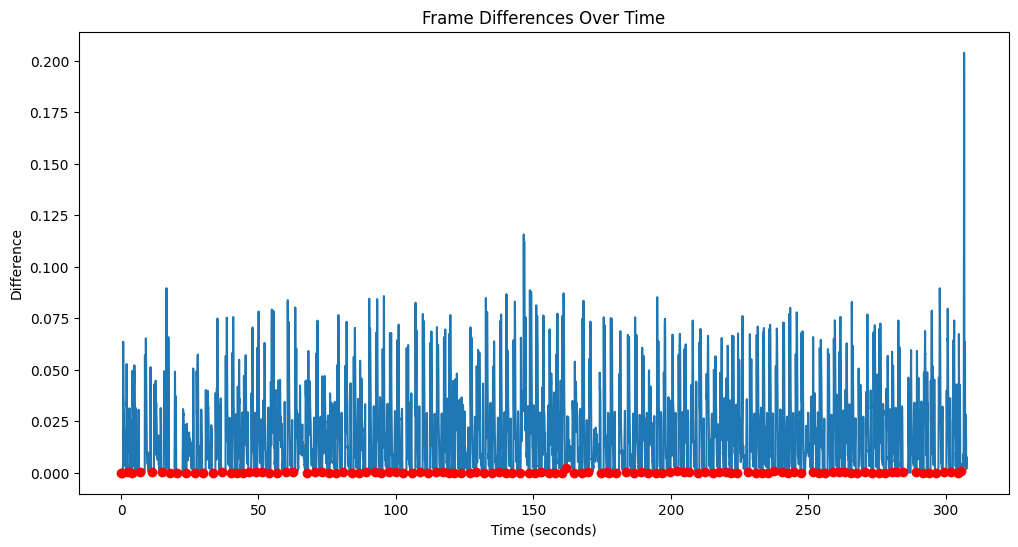

In [148]:
video_states = detect_video_states('data/uno_all/uno_all.mp4', frame_skip=2, min_difference_threshold=0.0025, min_consecutive_frames=8, debug=True)

In [1]:
print(19 * 4 + 8 + 8 + 8 + 4 + 4 + 1) #num of cards

109


In [2]:
print(10 * 4 + 4 + 4 + 4 + 3) #num of unique cards

55


In [149]:
display_unique_states_with_differences(video_states, start_time=0, end_time=60)

100%|██████████| 22/22 [00:00<00:00, 22.59it/s]


In [68]:
import matplotlib.pyplot as plt

def plot_differences_from_file(start_time, end_time, file_path):
    # Initialize lists to hold the timestamps and differences
    timestamps = []
    differences = []

    # Open the file and read the lines
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line into timestamp and difference
            time, diff = line.strip().split(', ')
            time = float(time)
            diff = float(diff)
            
            # Check if the timestamp is within the start and end time
            if start_time <= time <= end_time:
                timestamps.append(time)
                differences.append(diff)

    # Plotting the differences
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, differences, label='Differences')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Difference')
    plt.title('Frame Differences Over Time')
    plt.legend()
    plt.show()

# Example usage:
# plot_differences_from_file(0, 30, '/mnt/data/differences_and_timestamps.txt')


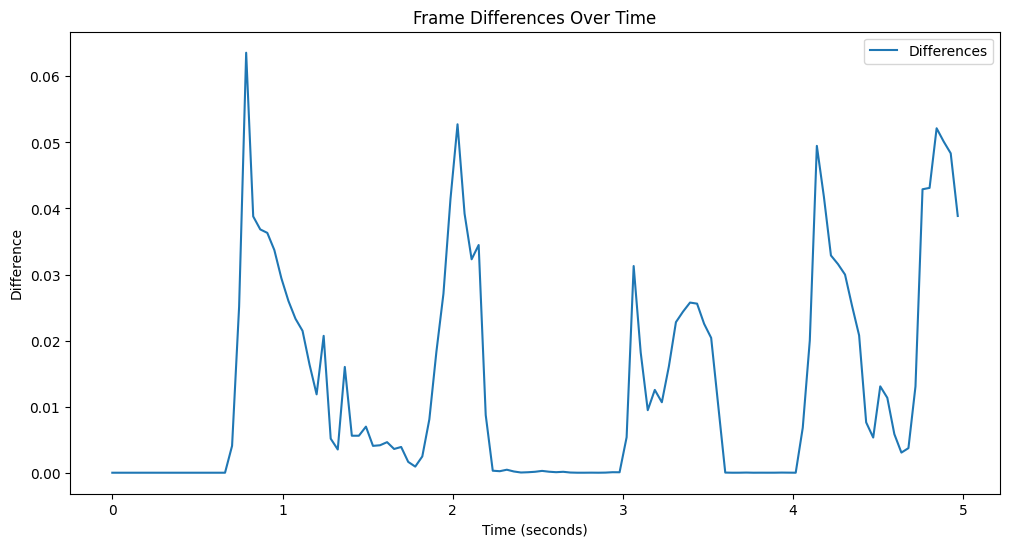

In [122]:
plot_differences_from_file(0, 5, 'differences_and_timestamps.txt')

In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

def visualize_differences_in_range(video_source, start_time, end_time, fps=30, frame_skip=1, scale_percent=25):
    cap = cv2.VideoCapture(video_source)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30

    # Calculate the start and end frame numbers based on the provided times and fps
    start_frame_number = int(start_time * fps)
    end_frame_number = int(end_time * fps)

    current_frame_number = 0
    previous_frame = None

    # Calculate how many frames we will actually be plotting (considering frame_skip)
    num_frames_to_plot = ((end_frame_number - start_frame_number) // frame_skip) + 1

    # Calculate the number of rows needed
    cols = 3  # Number of columns (previous frame, current frame, difference)
    rows = math.ceil(num_frames_to_plot / (cols // 3))

    # Create a figure with the appropriate size
    plt.figure(figsize=(15, rows * 5))

    subplot_index = 1  # Initialize subplot index
    
    # Read frames until the end time
    while current_frame_number < end_frame_number:
        ret, frame = cap.read()
        if not ret:
            break

        current_frame_number += 1
        if current_frame_number < start_frame_number or current_frame_number % frame_skip != 0:
            continue

        current_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if previous_frame is not None:
            abs_diff = cv2.absdiff(current_frame_gray, previous_frame)
            _, thresholded_diff = cv2.threshold(abs_diff, 10, 255, cv2.THRESH_TOZERO)
            thresholded_diff = np.uint8(thresholded_diff)
            heatmap = cv2.applyColorMap(thresholded_diff, cv2.COLORMAP_JET)
            overlayed_heatmap = cv2.addWeighted(frame, 0.7, heatmap, 0.3, 0)
            
            diff = calculate_absolute_difference(current_frame_gray, previous_frame)
        
            # Displaying images
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.imshow(resize_image(previous_frame, scale_percent), cmap='gray')
            plt.title(f"Previous Frame: {timestamp_from_frame_number((current_frame_number - 1), fps)}")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(resize_image(current_frame_gray, scale_percent), cmap='gray')
            plt.title(f"Current Frame: {timestamp_from_frame_number(current_frame_number, fps)}")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(resize_image(overlayed_heatmap, scale_percent))
            plt.title(f"Diff: {diff}")
            plt.axis('off')
            
            plt.show()

        previous_frame = current_frame_gray

    cap.release()
    plt.tight_layout()
    plt.show()

# Example usage
# visualize_differences_in_range('path_to_video.mp4', start_time=0, end_time=30)


In [ ]:
visualize_differences_in_range('data/uno_all/uno_all.mp4', start_time=2, end_time=3, frame_skip=2)